In [1]:
"""
You need to run this cell for the code in following cells to work.
"""

# Enable module reloading
%load_ext autoreload
%autoreload 2

import os
os.chdir("..")

In [2]:
import math

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

import xgboost as xgb

from src.data.preprocessing.utils import filter_data, merge_data
from src.data.feature_unions import merged_fu, merged_fu_without_outliers
from src.experiments.metrics import rmse, nrmse, rmsle

In [48]:
def compute_metrics(y_true, y_pred, metrics):
    results = {}
    for metric_name, metric_fn in metrics.items():
        results[metric_name] = metric_fn(y_true, y_pred)
    return results

metrics = {
    'rmse': rmse,
    'nrmse': nrmse,
    'rmsle': rmsle
}

def check_sites_transferability(model, metrics, buildings_data, weather_data, meter_data):
    results = {key: [] for key in metrics}
    results['site_id'] = [i for i in range(16)]
    
    for i in results['site_id']:
        buildings_data_site, weather_data_site, meter_data_site = filter_data(
            buildings_data, weather_data, meter_data, site_id=i, meter=0, meter_reading=200
        )
        data_site = merge_data(buildings_data_site, weather_data_site, meter_data_site)
        y_site = data_site[['meter_reading']].values.ravel()
        
        y_site_pred = model.predict(data_site)
        scores = compute_metrics(y_site, y_site_pred, metrics)
        
        for metric_name, metric_value in scores.items():
            results[metric_name].append(metric_value)
    return results

In [4]:
%%time
buildings_data = pd.read_csv('data/building_metadata.csv')
weather_data = pd.read_csv('data/weather_train.csv')
meter_data = pd.read_csv('data/train.csv')

CPU times: user 8.82 s, sys: 802 ms, total: 9.62 s
Wall time: 10.6 s


# Transferability between sites

In this experiment, we test performance on sites that were not used in training.

In [5]:
%%time
buildings_data_site_id0, weather_data_site_id0, meter_data_site_id0 = filter_data(
    buildings_data, weather_data, meter_data, site_id=0, meter=0, meter_reading=200
)
data = merge_data(buildings_data_site_id0, weather_data_site_id0, meter_data_site_id0)

CPU times: user 3.1 s, sys: 400 ms, total: 3.5 s
Wall time: 3.5 s


In [6]:
y = data[['meter_reading']].values.ravel()
len(y), y

(605288,
 array([  0.    ,   0.    ,   0.    , ...,  47.2332, 142.245 , 132.802 ]))

In [11]:
%%time
model = Pipeline([
    ('features', merged_fu_without_outliers),
    ('model', xgb.XGBRegressor(
        n_jobs=-1, objective='reg:squarederror', booster='gbtree', max_depth=3, eta=0.1, n_estimators=500,
        reg_lambda=0
    ))
])
_ = model.fit(data, y)

CPU times: user 3min 30s, sys: 409 ms, total: 3min 30s
Wall time: 4min 49s


In [12]:
y_pred = model.predict(data)

In [49]:
%%time
results = check_sites_transferability(model, metrics, buildings_data, weather_data, meter_data)

CPU times: user 4min 40s, sys: 8.9 s, total: 4min 49s
Wall time: 48min 2s


In [51]:
df = pd.DataFrame(results)
df

,rmse,nrmse,rmsle,site_id
0,15.639632,7.819933,0.884609,0
1,14.774578,7.389617,0.377237,1
2,20.574284,10.287657,0.496183,2
3,14.899298,7.450021,0.361269,3
4,21.838129,10.919119,0.522909,4
5,12.460356,6.233295,0.503529,5
6,19.726097,9.863887,0.439222,6
7,21.723310,10.863828,0.644325,7
8,8.730745,4.374493,0.765496,8
9,26.191833,13.103779,0.803963,9


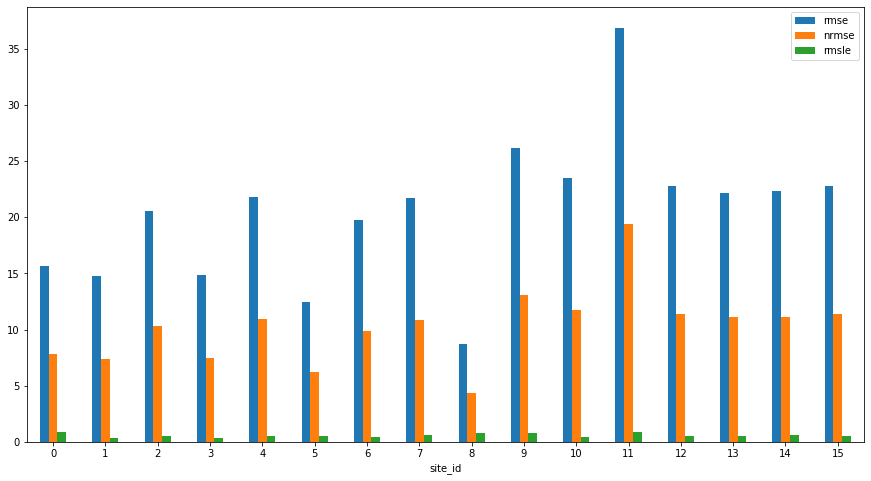

In [59]:
df.plot(x='site_id', y=['rmse', 'nrmse', 'rmsle'], kind='bar', rot=0, figsize=(15, 8))

Site 0 is baseline, towards this site comparisons are made.

In the graph above, we can see that performance in most sites is worse, but there are some exceptions. Next we examine performance in site 0 with respect to mean performance in other sites.  

In [76]:
df_mean = pd.DataFrame(
    {
        'site_id': [0, 'others'],
        'rmse': [df[df.site_id == 0].rmse.values[0], df[df.site_id > 0].rmse.mean()],
        'nrmse': [df[df.site_id == 0].nrmse.values[0], df[df.site_id > 0].nrmse.mean()],
        'rmsle': [df[df.site_id == 0].rmsle.values[0], df[df.site_id > 0].rmsle.mean()]
    }
)
df_mean

,site_id,rmse,nrmse,rmsle
0,0,15.639632,7.819933,0.884609
1,others,20.761716,10.444464,0.561463


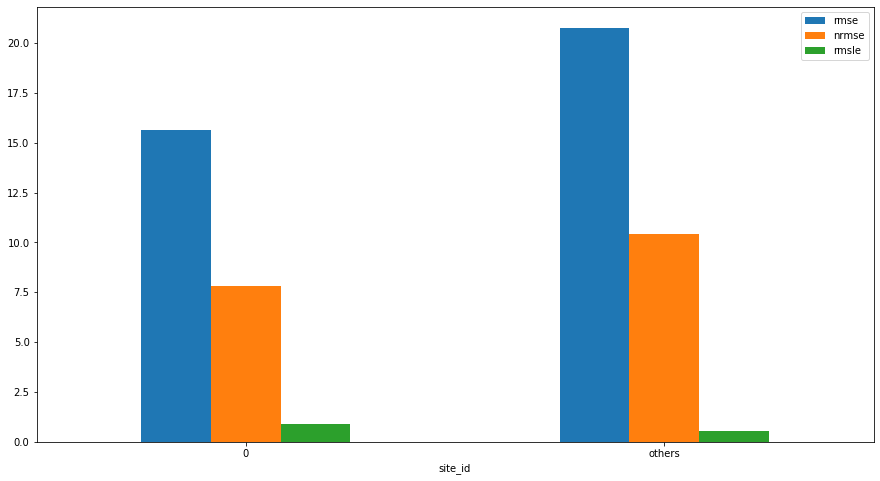

In [77]:
df_mean.plot(x='site_id', y=['rmse', 'nrmse', 'rmsle'], kind='bar', rot=0, figsize=(15, 8))

As we can see from the graph above, performance is a little bit worse but difference is not so significant. We can conclude that generalization of our model is quite good.